c:\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
688/688 - 6146s - 9s/step - accuracy: 0.9939 - loss: 0.0889 - val_accuracy: 1.0000 - val_loss: 0.0424
Epoch 2/10
688/688 - 5740s - 8s/step - accuracy: 1.0000 - loss: 0.0415 - val_accuracy: 1.0000 - val_loss: 0.0373
Epoch 3/10
688/688 - 11014s - 16s/step - accuracy: 1.0000 - loss: 0.0361 - val_accuracy: 1.0000 - val_loss: 0.0333
Epoch 4/10
688/688 - 11273s - 16s/step - accuracy: 1.0000 - loss: 0.0317 - val_accuracy: 1.0000 - val_loss: 0.0292
Epoch 5/10
688/688 - 12527s - 18s/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 1.0000 - val_loss: 0.0249
Epoch 6/10
688/688 - 11636s - 17s/step - accuracy: 1.0000 - loss: 0.0230 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 7/10
688/688 - 11805s - 17s/step - accuracy: 1.0000 - loss: 0.0186 - val_accuracy: 1.0000 - val_loss: 0.0163
Epoch 8/10
688/688 - 8233s - 12s/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 9/10
688/688 - 6103s - 9s/step - accuracy: 1.0000 - loss: 0.0108 - val_accuracy

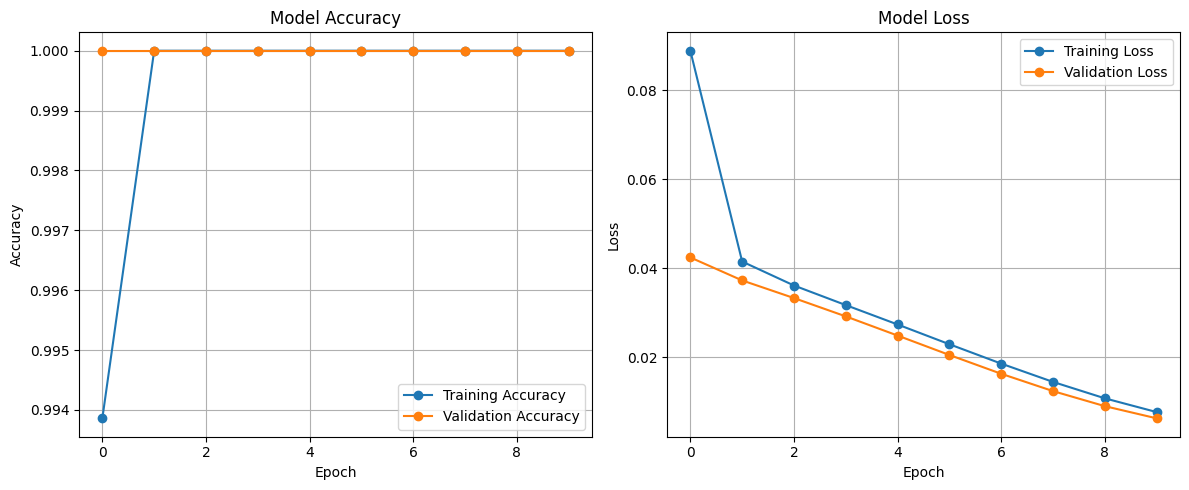

In [1]:
# Step 1: Import necessary libraries
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Load dataset
df = pd.read_csv(r'C:\Users\ksvsu\OneDrive\Desktop\Minor Project\Tweets.csv',
                 encoding='ISO-8859-1', header=None, on_bad_lines='skip')
df.columns = ['target', 'id', 'date', 'text']

# Step 3: Simplify target labels (0 = negative, 4 = positive to binary 0 and 1)
df['target'] = df['target'].apply(lambda x: 1 if x == 4 else 0)

# Step 4: Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data using the BERT tokenizer
def tokenize_tweets(tweets, tokenizer, max_length=128):
    return tokenizer(
        tweets.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

tokens = tokenize_tweets(df['text'], tokenizer)

# Prepare inputs for TensorFlow
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']

# **Convert TensorFlow tensors to NumPy arrays**
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()
targets_np = df['target'].values

# **Step 5: Split the data into training and validation sets**
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids_np, attention_masks_np, targets_np,
    test_size=0.2, random_state=42, stratify=targets_np
)

# Step 6: Define a function to create TensorFlow datasets
def create_tf_dataset(inputs, masks, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': inputs, 'attention_mask': masks}, labels))
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

batch_size = 32
train_dataset = create_tf_dataset(train_inputs, train_masks, train_labels, batch_size)
val_dataset = create_tf_dataset(val_inputs, val_masks, val_labels, batch_size)

# Step 7: Create a custom BERT model with additional layers and regularization
class CustomBERTModel(tf.keras.Model):
    def __init__(self, base_model):
        super(CustomBERTModel, self).__init__()
        self.base_model = base_model
        self.dropout = Dropout(0.5)  # Increased dropout rate
        self.classifier = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))  # L2 regularization

    def call(self, inputs, training=False):
        outputs = self.base_model(inputs)
        pooled_output = outputs.pooler_output  # Use the pooled output for classification
        x = self.dropout(pooled_output, training=training)
        return self.classifier(x)

# Load pre-trained BERT and attach custom layers
base_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')
model = CustomBERTModel(base_model.bert)

# Step 8: Define loss, optimizer, and metrics
loss_fn = SparseCategoricalCrossentropy(from_logits=False)
optimizer = Adam(learning_rate=3e-5)  # Use a standard learning rate for fine-tuning BERT

# Step 9: Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Step 10: Implement early stopping with stricter patience
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Step 11: Train the model with early stopping and weight decay
history = model.fit(
    train_dataset,
    epochs=10,  # Allow for more epochs to stabilize training
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=2
)

# Step 12: Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Print confirmation to check code progression
print("Model evaluation complete. Proceeding to plotting.")

# Step 13: Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
